<a href="https://colab.research.google.com/github/HimanshakChawla/A-B-Testing-and-Uplift-Modeling-ML/blob/main/A_B_Testing_and_Uplift_Modeling_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Title**

Predicting Customer Response to Marketing Campaigns in a Fast-Food Chain using A/B Testing and Uplift Modeling

**Business Context:**

A fast-food chain has launched two different marketing campaigns (Campaign A and Campaign B) to promote a new product. These campaigns are being tested via an A/B testing framework across a large customer base. The company wants to not only determine which campaign is more effective overall, but also predict which type of customer responds better to which campaign. This will allow for more targeted marketing in future campaigns.

**Objective:**

Develop a machine learning model that:
	1.	Predicts the likelihood of a customer responding positively (e.g., making a purchase) based on demographic and behavioral data.
	2.	Identifies customer segments that show differential uplift — i.e., who benefits more from Campaign A versus Campaign B.
	3.	Recommends the optimal campaign for each customer to maximize conversion rate and return on marketing investment (ROMI).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import copy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import joblib

In [2]:
def GetValuesCounts(data):
    import pandas as pd
    columns = [col for col in data.columns ]

    for col in columns:
        print(data[col].value_counts(),"\n")

In [3]:
def GetObjectFeatures(data) :
    object_columns = [col for col in data.columns if data[col].dtype == 'object']

    for col in object_columns :
        print(data[col].value_counts(),"\n")

In [4]:
data = pd.read_csv("/content/drive/MyDrive/WA_Marketing-Campaign.csv")
df=pd.DataFrame(data)

In [5]:
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [6]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [8]:
print("\nMissing Values: ")
print(df.isnull().sum())


Missing Values: 
MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64


In [9]:
# Check duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# Drop if needed
df = df.drop_duplicates()

Number of duplicate rows: 0


In [10]:
df = df.rename(columns={
    'SalesInThousands': 'sales',
    'Promotion': 'promo_group'
})

In [11]:
# Basic statistics
df.describe(include='all')

# Grouped by promo_group
df.groupby('promo_group')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
promo_group,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


**EDA**

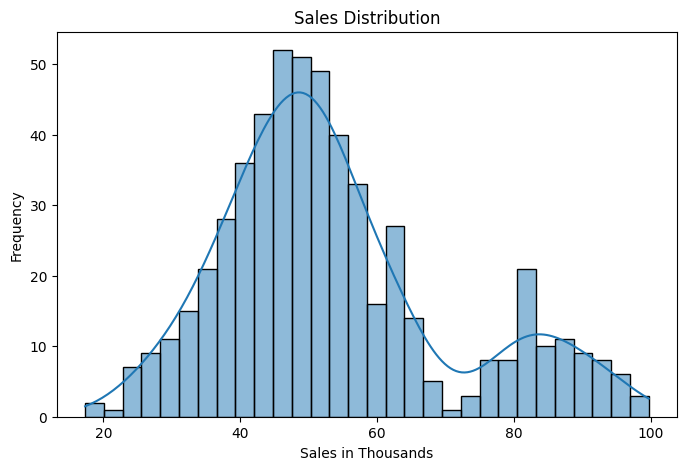

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sales histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['sales'], bins=30, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales in Thousands')
plt.ylabel('Frequency')
plt.show()

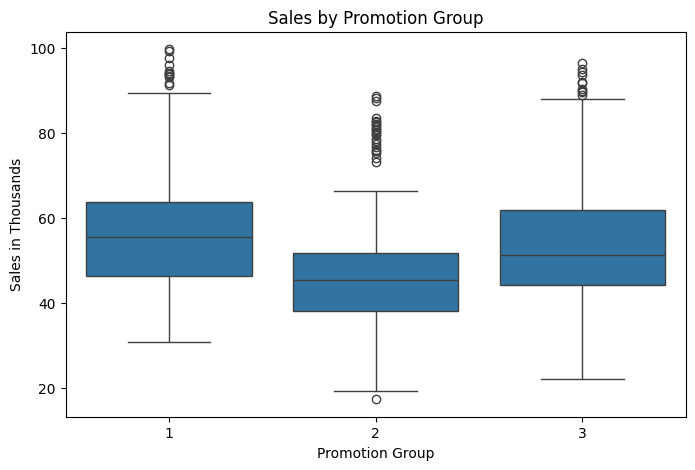

In [13]:
# Box plot: Sales across promo groups
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='promo_group', y='sales')
plt.title('Sales by Promotion Group')
plt.xlabel('Promotion Group')
plt.ylabel('Sales in Thousands')
plt.show()

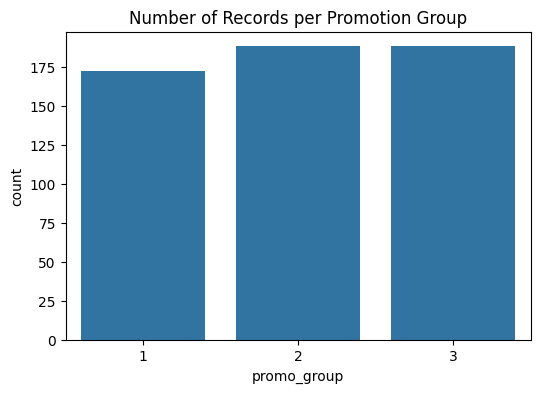

In [14]:
# Count of locations per promo group
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='promo_group')
plt.title('Number of Records per Promotion Group')
plt.show()

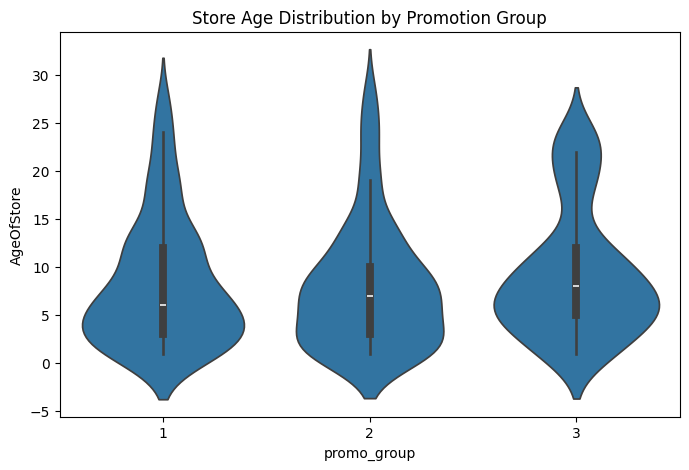

In [15]:
# Violin plot for AgeOfStore vs sales
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='promo_group', y='AgeOfStore')
plt.title('Store Age Distribution by Promotion Group')
plt.show()

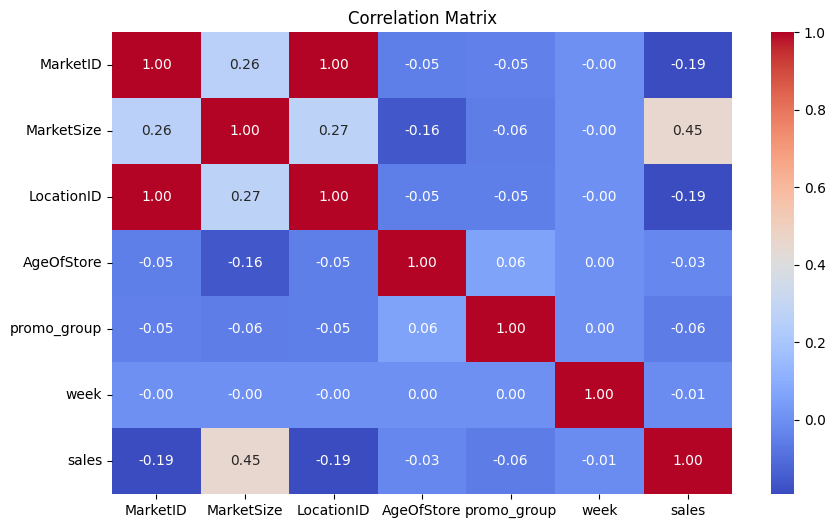

In [16]:
# Encode categorical MarketSize before correlation
df_corr = df.copy()
df_corr['MarketSize'] = df_corr['MarketSize'].map({'Small': 0, 'Medium': 1, 'Large': 2})

plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Q1: Do certain promotion groups lead to higher average sales?

Yes — from your promo_group (values 1, 2, 3), we can calculate average sales:

In [17]:
df.groupby('promo_group')['sales'].mean()

,sales
promo_group,
1,58.099012
2,47.329415
3,55.364468


promo_group 1 has the highest average sales-> most effective

Q2: Are there outliers in sales data?

<Axes: xlabel='promo_group', ylabel='sales'>

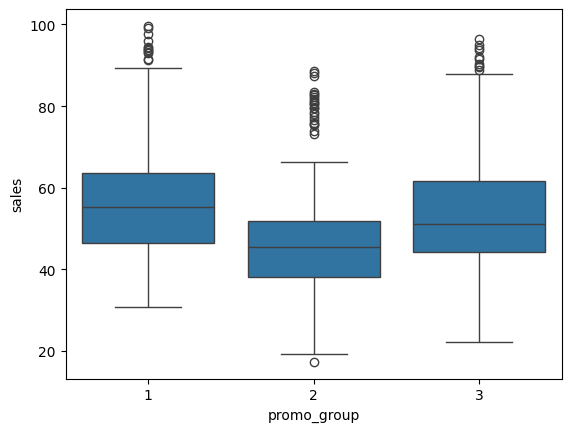

In [18]:
sns.boxplot(data=df, x='promo_group', y='sales')

Q3: Are older stores performing better?

<Axes: xlabel='AgeOfStore', ylabel='sales'>

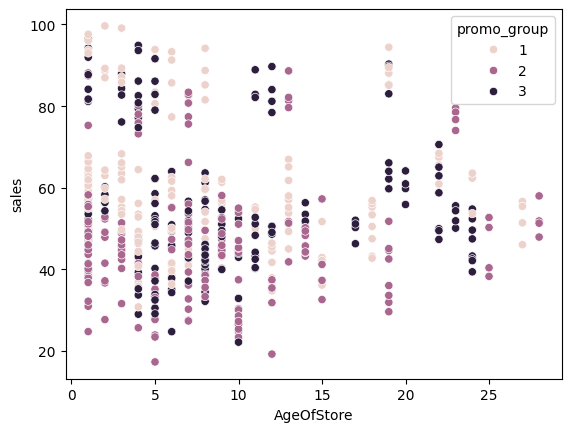

In [19]:
sns.scatterplot(data=df, x='AgeOfStore', y='sales', hue='promo_group')

**Feature Engineering**

In [20]:
df['MarketSize_encoded'] = df['MarketSize'].map({'Small': 0, 'Medium':1,'Large':2})

<Axes: xlabel='sales', ylabel='Count'>

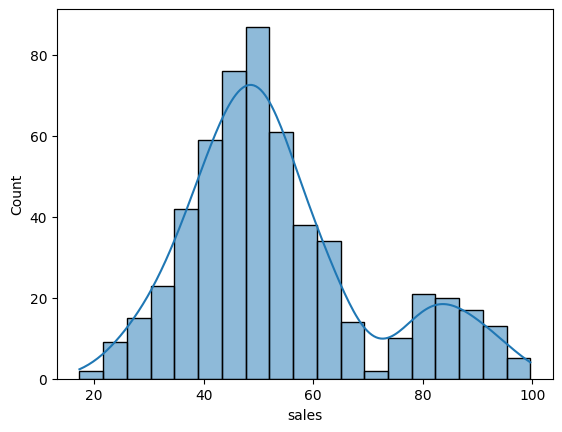

In [21]:
sns.histplot(df['sales'], kde=True)

In [22]:
features = ['AgeOfStore', 'week', 'MarketSize_encoded', 'promo_group']
target = 'sales'  # or 'log_sales' if transformed

In [23]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"\n{name} Performance:")
    print(f"R² Score     : {r2:.4f}")
    print(f"MAE          : {mae:.4f}")
    print(f"RMSE         : {rmse:.4f}")

    return {'Model': name, 'R2': r2, 'MAE': mae,'RMSE':rmse}

In [25]:
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_result = evaluate_model("Linear Regression", lr, X_test, y_test)

# 2. Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_result = evaluate_model("Random Forest", rf, X_test, y_test)

# 3. Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_result = evaluate_model("Gradient Boosting", gb,X_test,y_test)


Linear Regression Performance:
R² Score     : 0.2041
MAE          : 12.6855
RMSE         : 15.2968

Random Forest Performance:
R² Score     : 0.4582
MAE          : 9.6084
RMSE         : 12.6205

Gradient Boosting Performance:
R² Score     : 0.5952
MAE          : 8.6915
RMSE         : 10.9086


1. Gradient Boosting is the **best-performing model** based on all three metrics.
2. Linear Regression performs poorly, suggesting the relationships between features and target are non-linear.
3. Random Forest is good, but Gradient Boosting captures patterns better for this dataset.



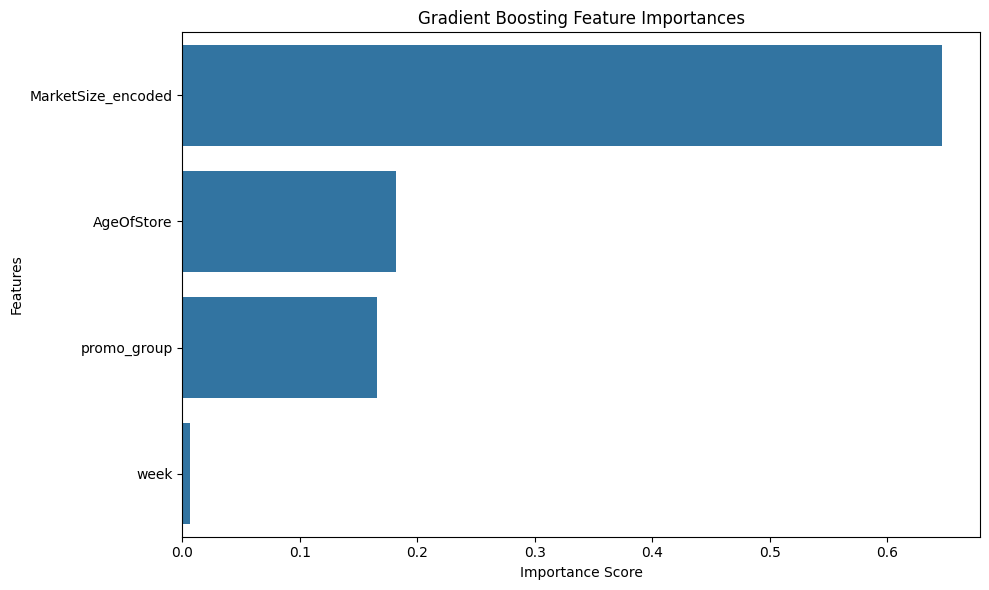

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

1. promo_group is a meaningful predictor of sales (15% importance).
This validates moving toward an uplift modeling approach — to optimize promotional targeting.
2. MarketSize dominates the signal. In your causal modeling, this must be controlled for — otherwise, it may confound your uplift estimates.

In [27]:
#T1 vs T2

df_t1_t2 = df[df['promo_group'].isin([1, 2])].copy()

# Binary treatment flag: 1 = T1, 0 = T2
df_t1_t2['treatment'] = df_t1_t2['promo_group'].apply(lambda x: 1 if x == 1 else 0)

# Features (drop promo_group to avoid leakage)
features = ['MarketSize_encoded', 'AgeOfStore', 'week']
X = df_t1_t2[features]
y = df_t1_t2['sales']
t = df_t1_t2['treatment']

In [28]:
#T1 vs T3
df_t1_t3 = df[df['promo_group'].isin([1, 3])].copy()

# Create binary treatment flag: 1 = T1 (promo_group=1), 0 = T3 (promo_group=3)
df_t1_t3['treatment'] = df_t1_t3['promo_group'].apply(lambda x: 1 if x == 1 else 0)

# Select features (drop promo_group itself)
features_t1_t3 = ['MarketSize_encoded', 'AgeOfStore', 'week']
X_t1_t3 = df_t1_t3[features_t1_t3]
y_t1_t3 = df_t1_t3['sales']
t_t1_t3 = df_t1_t3['treatment']

In [29]:
#T2 vs T3
df_t2_t3 = df[df['promo_group'].isin([2, 3])].copy()

# Create binary treatment flag: 1 = T2 (promo_group=2), 0 = T3 (promo_group=3)
df_t2_t3['treatment'] = df_t2_t3['promo_group'].apply(lambda x: 1 if x == 2 else 0)

# Select features (drop promo_group itself)
features_t2_t3 = ['MarketSize_encoded', 'AgeOfStore', 'week']
X_t2_t3 = df_t2_t3[features_t2_t3]
y_t2_t3 = df_t2_t3['sales']
t_t2_t3 = df_t2_t3['treatment']

In [30]:
#T1 and T2 groups
df_t1_t2 = df[df['promo_group'].isin([1, 2])].copy()

# Create binary treatment column: 1 if promo_group == 1 (T1), else 0 (T2)
df_t1_t2['treatment'] = df_t1_t2['promo_group'].apply(lambda x: 1 if x == 1 else 0)

# Features (excluding 'promo_group')
features = ['MarketSize_encoded', 'AgeOfStore', 'week']
X = df_t1_t2[features]
y = df_t1_t2['sales']
t = df_t1_t2['treatment']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.2, stratify=t, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor

# Split training data into treated and control
X_train_treated = X_train[t_train == 1]
y_train_treated = y_train[t_train == 1]

X_train_control = X_train[t_train == 0]
y_train_control = y_train[t_train == 0]

# Fit separate models
model_treated = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_control = GradientBoostingRegressor(n_estimators=100, random_state=42)

model_treated.fit(X_train_treated, y_train_treated)
model_control.fit(X_train_control, y_train_control)

# Predict outcomes under treatment and control
y_pred_treated = model_treated.predict(X_test)
y_pred_control = model_control.predict(X_test)

# Estimated uplift = treatment - control
uplift_preds = y_pred_treated - y_pred_control

# Add to test set for inspection
import pandas as pd

results = X_test.copy()
results['actual'] = y_test.values
results['uplift_pred'] = uplift_preds
results['treatment'] = t_test.values

# Sort customers by predicted uplift descending
results_sorted = results.sort_values(by='uplift_pred', ascending=False)
results_sorted.head(10)

,MarketSize_encoded,AgeOfStore,week,actual,uplift_pred,treatment
492,2,10,1,45.21,41.441492,0
540,2,2,1,59.87,38.282515,1
524,2,3,1,53.51,38.005737,1
512,2,6,1,49.98,37.566778,0
536,2,6,1,49.62,37.566778,1
547,2,14,4,49.41,36.521905,0
523,2,9,4,45.90,33.926842,0
544,2,14,1,50.20,27.899340,0
521,2,9,2,43.44,26.440566,0
538,2,6,3,50.11,22.467789,1


In [31]:
# T1 and T3
df_t1_t3 = df[df['promo_group'].isin([1, 3])].copy()
df_t1_t3['treatment'] = df_t1_t3['promo_group'].apply(lambda x: 1 if x == 1 else 0)

X = df_t1_t3[features]
y = df_t1_t3['sales']
t = df_t1_t3['treatment']

# Train-test split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.2, stratify=t, random_state=42)

# Split by treatment
X_train_treat = X_train[t_train == 1]
y_train_treat = y_train[t_train == 1]

X_train_control = X_train[t_train == 0]
y_train_control = y_train[t_train == 0]

# Fit models
model_treat = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_control = GradientBoostingRegressor(n_estimators=100, random_state=42)

model_treat.fit(X_train_treat, y_train_treat)
model_control.fit(X_train_control, y_train_control)

# Predict uplift
uplift_pred_t1_t3 = model_treat.predict(X_test) - model_control.predict(X_test)

# Store results
results_t1_t3 = X_test.copy()
results_t1_t3['actual'] = y_test.values
results_t1_t3['uplift_pred'] = uplift_pred_t1_t3
results_t1_t3['treatment'] = t_test.values

# Preview
results_t1_t3.sort_values(by='uplift_pred', ascending=False).head()

,MarketSize_encoded,AgeOfStore,week,actual,uplift_pred,treatment
540,2,2,1,59.87,34.658743,1
535,2,14,4,50.20,30.794835,0
532,2,14,1,53.50,30.183619,0
485,2,2,2,60.24,20.397628,0
436,1,10,1,44.66,16.580032,0


In [32]:
# Filter data
df_t2_t3 = df[df['promo_group'].isin([2, 3])].copy()
df_t2_t3['treatment'] = df_t2_t3['promo_group'].apply(lambda x: 1 if x == 2 else 0)

X = df_t2_t3[features]
y = df_t2_t3['sales']
t = df_t2_t3['treatment']

# Train-test split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.2, stratify=t, random_state=42)

# Split by treatment
X_train_treat = X_train[t_train == 1]
y_train_treat = y_train[t_train == 1]

X_train_control = X_train[t_train == 0]
y_train_control = y_train[t_train == 0]

# Fit models
model_treat = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_control = GradientBoostingRegressor(n_estimators=100, random_state=42)

model_treat.fit(X_train_treat, y_train_treat)
model_control.fit(X_train_control, y_train_control)

# Predict uplift
uplift_pred_t2_t3 = model_treat.predict(X_test) - model_control.predict(X_test)

# Store results
results_t2_t3 = X_test.copy()
results_t2_t3['actual'] = y_test.values
results_t2_t3['uplift_pred'] = uplift_pred_t2_t3
results_t2_t3['treatment'] = t_test.values

# Preview
results_t2_t3.sort_values(by='uplift_pred', ascending=False).head()

,MarketSize_encoded,AgeOfStore,week,actual,uplift_pred,treatment
417,1,24,2,52.39,6.713144,0
302,1,24,3,43.29,5.122568,0
531,2,7,4,49.71,3.437895,1
479,2,7,4,50.05,3.437895,0
346,1,3,3,42.46,1.407878,1


In [33]:
def evaluate_uplift(results_df, name, top_percent=0.2):
    # Sort by predicted uplift
    results_sorted = results_df.sort_values(by='uplift_pred', ascending=False).reset_index(drop=True)

    # Top N%
    top_n = int(top_percent * len(results_sorted))
    top_group = results_sorted.iloc[:top_n]

    # Avg actual sales by treatment group
    treated_mean = results_sorted[results_sorted['treatment'] == 1]['actual'].mean()
    control_mean = results_sorted[results_sorted['treatment'] == 0]['actual'].mean()
    uplift_all = treated_mean - control_mean

    # Top group uplift
    top_treated_mean = top_group[top_group['treatment'] == 1]['actual'].mean()
    top_control_mean = top_group[top_group['treatment'] == 0]['actual'].mean()
    uplift_top = top_treated_mean - top_control_mean

    print(f"\n📊 {name} Evaluation")
    print(f"  - Avg Uplift (Treated - Control): {uplift_all:.3f}")
    print(f"  - Top {int(top_percent*100)}% Uplift: {uplift_top:.3f}")
    print(f"  - Control Avg (All): {control_mean:.3f}")
    print(f"  - Treated Avg (All): {treated_mean:.3f}")

In [34]:
evaluate_uplift(results, "T1 vs T2")
evaluate_uplift(results_t1_t3, "T1 vs T3")
evaluate_uplift(results_t2_t3,"T2 vs T3")


📊 T1 vs T2 Evaluation
  - Avg Uplift (Treated - Control): 9.379
  - Top 20% Uplift: 7.962
  - Control Avg (All): 46.124
  - Treated Avg (All): 55.503

📊 T1 vs T3 Evaluation
  - Avg Uplift (Treated - Control): 0.365
  - Top 20% Uplift: 4.529
  - Control Avg (All): 55.138
  - Treated Avg (All): 55.503

📊 T2 vs T3 Evaluation
  - Avg Uplift (Treated - Control): -9.986
  - Top 20% Uplift: 2.685
  - Control Avg (All): 55.138
  - Treated Avg (All): 45.152


In [35]:
PROMO_COST_PER_USER = 100  # ₹ or $
TOP_PERCENT = 0.2  # Top 20% of users

In [36]:
def evaluate_roi(results_df, name, top_percent=0.2, promo_cost=100):
    # Sort by predicted uplift
    results_sorted = results_df.sort_values(by='uplift_pred', ascending=False).reset_index(drop=True)

    top_n = int(top_percent * len(results_sorted))
    top_group = results_sorted.iloc[:top_n]

    # Mean actual sales
    treated_mean = top_group[top_group['treatment'] == 1]['actual'].mean()
    control_mean = top_group[top_group['treatment'] == 0]['actual'].mean()

    # Incremental Revenue per customer
    incremental_revenue = treated_mean - control_mean

    # ROI
    roi = (incremental_revenue - promo_cost) / promo_cost

    print(f"\n💰 {name} ROI Evaluation")
    print(f"  - Top {int(top_percent*100)}% Targeted Customers")
    print(f"  - Control Sales Avg: ₹{control_mean:.2f}")
    print(f"  - Treated Sales Avg: ₹{treated_mean:.2f}")
    print(f"  - Incremental Revenue: ₹{incremental_revenue:.2f}")
    print(f"  - ROI: {roi:.2f} ({roi*100:.1f}%)")

In [37]:
evaluate_roi(results, "T1 vs T2", top_percent=TOP_PERCENT, promo_cost=PROMO_COST_PER_USER)
evaluate_roi(results_t1_t3, "T1 vs T3", top_percent=TOP_PERCENT, promo_cost=PROMO_COST_PER_USER)
evaluate_roi(results_t2_t3, "T2 vs T3", top_percent=TOP_PERCENT, promo_cost=PROMO_COST_PER_USER)


💰 T1 vs T2 ROI Evaluation
  - Top 20% Targeted Customers
  - Control Sales Avg: ₹51.10
  - Treated Sales Avg: ₹59.06
  - Incremental Revenue: ₹7.96
  - ROI: -0.92 (-92.0%)

💰 T1 vs T3 ROI Evaluation
  - Top 20% Targeted Customers
  - Control Sales Avg: ₹49.33
  - Treated Sales Avg: ₹53.86
  - Incremental Revenue: ₹4.53
  - ROI: -0.95 (-95.5%)

💰 T2 vs T3 ROI Evaluation
  - Top 20% Targeted Customers
  - Control Sales Avg: ₹47.99
  - Treated Sales Avg: ₹50.68
  - Incremental Revenue: ₹2.68
  - ROI: -0.97 (-97.3%)


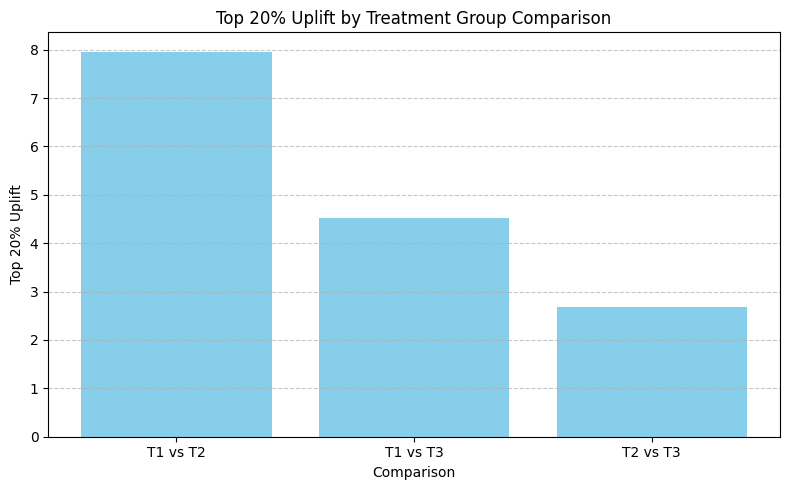

In [38]:
import matplotlib.pyplot as plt

# Labels and values
comparisons = ['T1 vs T2', 'T1 vs T3', 'T2 vs T3']
top20_uplifts = [7.962, 4.529, 2.685]

plt.figure(figsize=(8, 5))
plt.bar(comparisons, top20_uplifts, color='skyblue')
plt.title('Top 20% Uplift by Treatment Group Comparison')
plt.ylabel('Top 20% Uplift')
plt.xlabel('Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

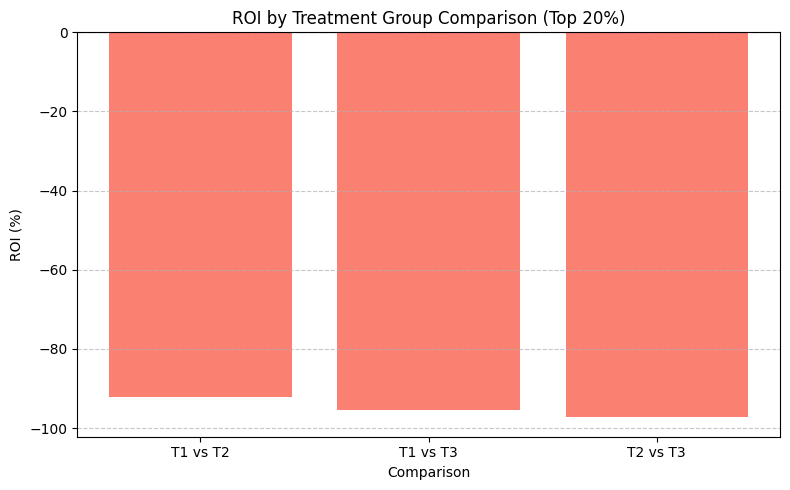

In [39]:
# ROI calculation
promotion_cost = 100
rois = [(x - promotion_cost) / promotion_cost * 100 for x in top20_uplifts]

plt.figure(figsize=(8, 5))
plt.bar(comparisons, rois, color='salmon')
plt.title('ROI by Treatment Group Comparison (Top 20%)')
plt.ylabel('ROI (%)')
plt.xlabel('Comparison')
plt.axhline(0, color='black', linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Step 1: Train two models
model_t = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_c = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit on treated data
# Corrected variable name from treatment_train to t_train
model_t.fit(X_train[t_train == 1], y_train[t_train == 1])

# Fit on control data
# Corrected variable name from treatment_train to t_train
model_c.fit(X_train[t_train == 0], y_train[t_train == 0])

# Step 2: Predict potential outcomes for test data
mu1 = model_t.predict(X_test)  # Predicted outcome if treated
mu0 = model_c.predict(X_test)  # Predicted outcome if control

# Step 3: Uplift score = mu1 - mu0
uplift_scores=mu1-mu0

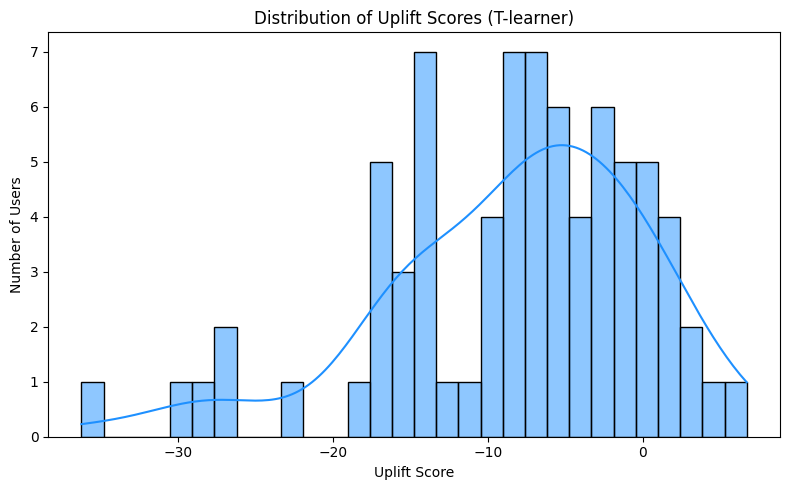

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot uplift score distribution
plt.figure(figsize=(8, 5))
sns.histplot(uplift_scores, bins=30, kde=True, color='dodgerblue')
plt.title("Distribution of Uplift Scores (T-learner)")
plt.xlabel("Uplift Score")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

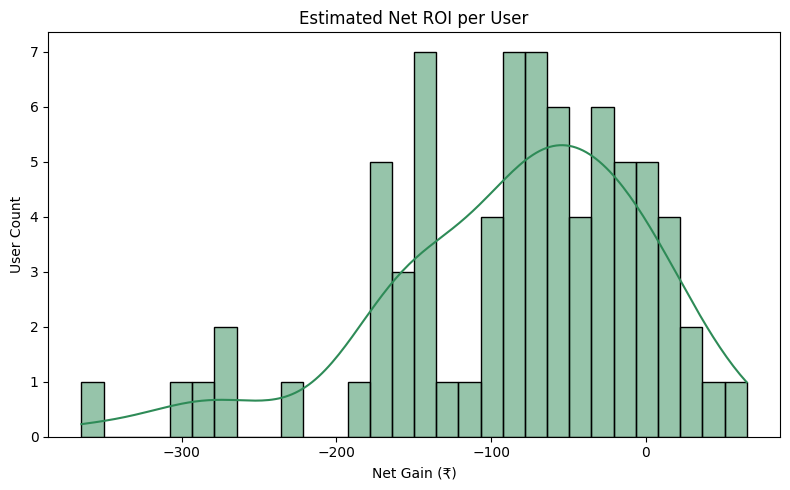

In [42]:
# Example assumptions
cost_per_user = 2.0
value_per_conversion = 10.0

# Estimated gain from uplift
expected_gain = uplift_scores * value_per_conversion
net_gain = expected_gain - cost_per_user

# Plot net gain
plt.figure(figsize=(8, 5))
sns.histplot(net_gain, bins=30, kde=True, color='seagreen')
plt.title("Estimated Net ROI per User")
plt.xlabel("Net Gain (₹)")
plt.ylabel("User Count")
plt.tight_layout()
plt.show()

In [43]:
import pandas as pd
top_n_percent = 0.2
threshold = pd.Series(uplift_scores).quantile(1 - top_n_percent)
import pandas as pd
top_n_percent = 0.2
threshold = pd.Series(uplift_scores).quantile(1 - top_n_percent)

target_users = uplift_scores >= threshold
print(f"Target {target_users.sum()} users (Top {int(top_n_percent * 100)}%)")

Target 16 users (Top 20%)


In [44]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [46]:
import streamlit as st
import pandas as pd
import joblib
def calculate_uplift(data, model_treated, model_control):
    mu1 = model_treated.predict(data)
    mu0 = model_control.predict(data)
    return mu1 - mu0

st.title("Uplift Modeling Dashboard")

uploaded_file = st.file_uploader("Upload your dataset", type=["csv"])
if uploaded_file:
    data = pd.read_csv(uploaded_file)
    st.write("Preview of Uploaded Data:", data.head())

    model_treated = joblib.load("model/model_treated.pkl")
    model_control = joblib.load("model/model_control.pkl")

    if st.button("Calculate Uplift"):
        uplift_scores = calculate_uplift(data, model_treated, model_control)
        data["Uplift Score"] = uplift_scores
        st.write(data[["Uplift Score"]].describe())

        # Show Top 20% Targeted Users
        top_20_thresh = uplift_scores.quantile(0.8)
        target_users = data[uplift_scores >= top_20_thresh]
        st.subheader("Top 20% Target Users")
        st.write(target_users)

        # Optional: Download button
        st.download_button("Download Target Users", target_users.to_csv(index=False), file_name="top_20_percent.csv")

2025-06-02 05:32:47.204 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 05:32:47.435 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-02 05:32:47.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 05:32:47.449 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 05:32:47.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 05:32:47.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 05:32:47.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 05:32:47.465 Thread 'MainThread': mi

In [49]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
